<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/projetNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Import of the training data

from google.colab import files
uploaded = files.upload()

Saving [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv to [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned (1).tsv


In [9]:
!pip install wikidata --quiet

import pandas as pd
from wikidata.client import Client
import requests

In [10]:
df_train = pd.read_csv('/content/[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv', sep = '\t')

#subclasses (P279)

##subclasses upward until the root

In [6]:
WIKIDATA_SPARQL_URL = "https://query.wikidata.org/sparql"

def get_superclass(qid):
    """ get the superclass to which qid is a subclass of """
    query = f"""
    SELECT ?superclass WHERE {{
      wd:{qid} wdt:P279 ?superclass.
    }}
    LIMIT 1 """
    #the first superclass is taken if there are several superclasses
    headers = {
        "Accept": "application/sparql-results+json",
        "User-Agent": "ExplorateurWikidata/0.1 (truc@truc.com)"
    }
    response = requests.get(WIKIDATA_SPARQL_URL, params={"query": query}, headers=headers)
    data = response.json()
    bindings = data["results"]["bindings"]
    if not bindings:
        return None
    superclass_uri = bindings[0]["superclass"]["value"]
    return superclass_uri.split("/")[-1]

def get_class_path(qid):
    """ find recursively the path to a "root" class"""
    path = [qid]
    current = qid
    while True:
        parent = get_superclass(current)
        if parent is None or parent in path:
            break
        path.append(parent)
        current = parent
    return path

def extract_entity_id(url):
    return url.strip().split("/")[-1]

def get_depth(url):
    qid = extract_entity_id(url)
    path_qids = get_class_path(qid)
    return len(path_qids)


In [7]:
df_subset = df_train.sample(n=50, random_state = 42)
df_subset["subclass_depth0"] = df_subset["item"].apply(get_depth)

In [11]:
import requests
from collections import deque

WIKIDATA_SPARQL_URL = "https://query.wikidata.org/sparql"
HEADERS = {
    "Accept": "application/sparql-results+json",
    "User-Agent": "ExplorateurWikidata/0.1 (truc@truc.com)"
}

def extract_entity_id(url):
    return url.strip().split("/")[-1]


def get_superclasses(qid):
    """direct superclasses(P279) of the item"""
    query = f"""
    SELECT ?superclass WHERE {{
      wd:{qid} wdt:P279 ?superclass.
    }}
    """
    response = requests.get(WIKIDATA_SPARQL_URL, params={"query": query}, headers=HEADERS)
    results = response.json()["results"]["bindings"]
    return [r["superclass"]["value"].split("/")[-1] for r in results]

def get_subclass_depth_bfs(url, max_depth=20):
    """minimale depth via BFS """
    qid = extract_entity_id(url)
    visited = set()
    queue = deque([(qid, 1)])  # (QID, depth)

    while queue:
        current_qid, depth = queue.popleft()
        if current_qid in visited:
            continue
        visited.add(current_qid)

        parents = get_superclasses(current_qid)
        if not parents:
            return depth  #root achieved
        if depth >= max_depth:
            return None  # avoid infinite loop
        for parent_qid in parents:
            queue.append((parent_qid, depth + 1))

    return None


In [13]:
df_train["subclass_depth"]= df_train["item"].apply(get_subclass_depth_bfs)

In [15]:
df_train.to_csv('trainset_subclass_depth.csv')

## Subclasses downward

In [18]:
def get_direct_subclasses(url):
    """return the number of subclasses """
    qid = extract_entity_id(url)
    query = f"""
    SELECT ?subclass WHERE {{
      ?subclass wdt:P279 wd:{qid} .
    }}
    """
    response = requests.get(WIKIDATA_SPARQL_URL, params={"query": query}, headers=HEADERS)
    results = response.json()["results"]["bindings"]
    #return [r["subclass"]["value"].split("/")[-1] for r in results]
    return len(results)


In [35]:
df_subset = df_train.sample(n=50, random_state = 42)
df_subset["direct_subclasses"] = df_subset["item"].apply(get_direct_subclasses)

In [19]:
df_train["subclasses"] = df_train["item"].apply(get_direct_subclasses)

In [26]:
df_train.drop(columns = "subclass_depth").to_csv('trainset_subclasses.csv')

# Instances of (P31)

In [9]:
def get_instances_of(url):
  qid = extract_entity_id(url)
  """return direct 'instance of' (P31)"""
  query = f"""
  SELECT ?class ?label WHERE {{
    wd:{qid} wdt:P31 ?class .
    ?class rdfs:label ?label .
    FILTER(LANG(?label) = "en")
  }}
  """
  response = requests.get(WIKIDATA_SPARQL_URL, params={"query": query}, headers=HEADERS)
  results = response.json()["results"]["bindings"]
  #return [(r["class"]["value"].split("/")[-1], r["label"]["value"]) for r in results ]
  return len(results)


In [10]:
df_train["instances_of"] = df_train["item"].apply(get_instances_of)

In [11]:
df_train

,item,name,description,type,category,subcategory,label,instances_of
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,cultural exclusive,1
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,cultural representative,1
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,cultural representative,1
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,cultural representative,1
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,cultural representative,1
...,...,...,...,...,...,...,...,...
6246,http://www.wikidata.org/entity/Q321103,Bühl,"quarter of Tübingen, Baden-Württemberg, Germany",entity,geography,neighborhood,cultural exclusive,2
6247,http://www.wikidata.org/entity/Q338167,Tenderloin,area of New York City during the late 19th and...,entity,geography,neighborhood,cultural exclusive,1
6248,http://www.wikidata.org/entity/Q66991,Schinznach-Dorf,former municipality and current district of Sc...,entity,geography,neighborhood,cultural exclusive,3
6249,http://www.wikidata.org/entity/Q66922,Ependes,village and former municipality in Bois-d'Amon...,entity,geography,neighborhood,cultural exclusive,2


In [12]:
df_train.to_csv('train_set_instances.csv')

In [22]:
df = df_train.loc[lambda x: x.label == "cultural agnostic"]
df1 = df_train.loc[lambda x: x.label != "cultural agnostic"]

In [18]:
import matplotlib.pyplot as plt

In [26]:
# Distribution des valeurs
counts = df["instances_of"].value_counts().sort_index()

counts1 = df1["instances_of"].value_counts().sort_index()

# Proportions (en % ou ratio)
proportions = counts / counts.sum()

proportions1 = counts1 / counts1.sum()


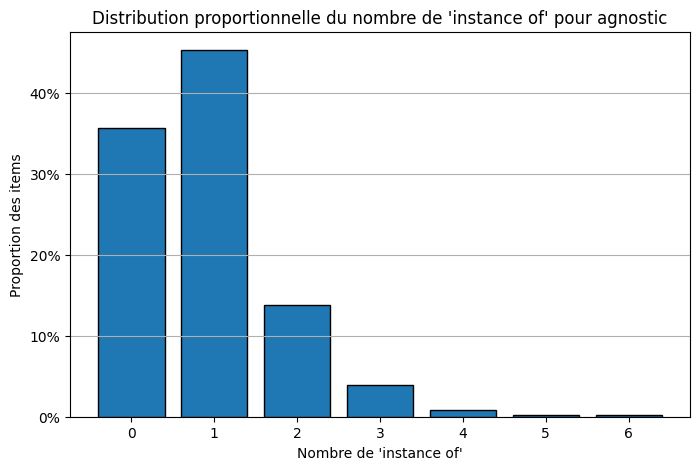

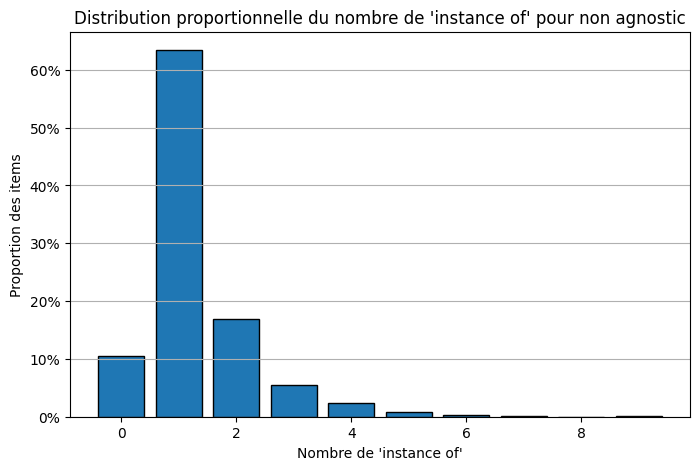

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.bar(proportions.index, proportions.values, width=0.8, edgecolor='black')

plt.title("Distribution proportionnelle du nombre de 'instance of' pour agnostic")
plt.xlabel("Nombre de 'instance of'")
plt.ylabel("Proportion des items")
plt.grid(axis='y')

# Optionnel : afficher en pourcentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

plt.figure(figsize=(8, 5))
plt.bar(proportions1.index, proportions1.values, width=0.8, edgecolor='black')

plt.title("Distribution proportionnelle du nombre de 'instance of' pour non agnostic")
plt.xlabel("Nombre de 'instance of'")
plt.ylabel("Proportion des items")
plt.grid(axis='y')

# Optionnel : afficher en pourcentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

plt.show()
